In [1]:
from datasets import load_dataset
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict
import math


c:\Users\zerok\miniconda3\envs\EI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


https://huggingface.co/datasets/Sp1786/multiclass-sentiment-analysis-dataset

In [14]:
train_dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset", split='train')
test_dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset", split='test')
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)
df = pd.concat([train_df, test_df], ignore_index=True)

In [4]:
# Save the initial DataFrame to a CSV file
df.to_csv('../data/raw/sentiment_data.csv', index=False)


In [ ]:

# Load the DataFrame back from the CSV if needed (optional since you already have dfReddit loaded)
df = pd.read_csv('../data/raw/sentiment_data.csv')


In [17]:
train_df

,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative
...,...,...,...,...
31227,6265,Grrrr....I got the wrong size coat for the sheep,0,negative
31228,11284,4 cases of swine flu!,1,neutral
31229,6436,excellent,2,positive
31230,860,is sitting thru the boring bits in Titanic wai...,1,neutral


In [17]:
df['text'] = df['text'].fillna('')
test_df['text'] = test_df['text'].fillna('')
train_df['text'] = train_df['text'].fillna('')

In [15]:
test_df


,id,text,label,sentiment
0,9235,getting cds ready for tour,1,neutral
1,16790,"MC, happy mother`s day to your mom ;).. love yah",2,positive
2,24840,A year from now is graduation....i am pretty s...,0,negative
3,20744,because you had chips and sale w/o me,1,neutral
4,6414,Great for organising my work life balance,2,positive
...,...,...,...,...
5201,10277,Fuck no internet damn time warner!,0,negative
5202,8610,Looking forward to android 1.5 being pushed t...,1,neutral
5203,8114,Not good. Wasted time.,0,negative
5204,3034,"U were great, as always. But, can`t we do an ...",2,positive


In [6]:

# Save the training and testing DataFrames to CSV files
train_df.to_csv('../data/clean/train.csv', index=False)
test_df.to_csv('../data/clean/test.csv', index=False)


In [ ]:

# Optionally, reload them to verify everything worked as expected
train_df = pd.read_csv('../data/clean/train.csv')
test_df = pd.read_csv('../data/clean/test.csv')

In [36]:

def load_sentiment_scores(file_path):
    """
    Load sentiment scores from a file into a dictionary.
    """
    sentiment_scores = {}
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            if len(parts) != 2:
                continue
            word, score = parts
            sentiment_scores[word] = int(score)
    return sentiment_scores

# Load sentiment scores
sentiment_scores = load_sentiment_scores('sentiment_dict.txt')


In [37]:
def calculate_ratios(data):
    """
    Calculate the ratio of positive, negative, and neutral comments in the dataset.
    """
    total_reviews = len(data)
    if total_reviews == 0:
        return 0, 0, 0
    pos_count = len(data[data['sentiment'] == 'positive'])
    neg_count = len(data[data['sentiment'] == 'negative'])
    neu_count = len(data[data['sentiment'] == 'neutral'])

    pos_ratio = pos_count / total_reviews
    neg_ratio = neg_count / total_reviews
    neu_ratio = neu_count / total_reviews

    return pos_ratio, neg_ratio, neu_ratio

# Calculate ratios for the combined dataset
pos_ratio, neg_ratio, neu_ratio = calculate_ratios(df)

In [38]:

def split_data_by_sentiment(data, sentiment):
    return data[data['sentiment'] == sentiment]['text'].tolist()

# Split the data into positive and negative comments
positive_reviews = split_data_by_sentiment(train_df, 'positive')
negative_reviews = split_data_by_sentiment(train_df, 'negative')
neutral_reviews = split_data_by_sentiment(train_df, 'neutral')


In [28]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zerok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [39]:
from nltk.tokenize import word_tokenize
negation_words = {"not", "no", "never", "n't", "cannot", "do not", "does not", "no", "not", "don't", "hardly", "cannot", "shouldn’t", "doesnt", "lack", "daren’t", "wasn’t", "didnt", "lacking", "don’t", "wouldn’t", "hadnt", "lacks", "doesn’t", "weren’t", "hasn’t", "neither", "didn’t", "won’t", "havn’t", "nor", "hadn’t", "without", "haven’t"}
punctuation_marks = set(string.punctuation)
stemmer = PorterStemmer()

def preprocess_reviews(review):
    if review is None or not isinstance(review, str):
        review = str(review)
    
    review = review.lower()
    tokens = word_tokenize(review)
    
    negated = False
    processed_tokens = []
    for token in tokens:
        if token in punctuation_marks:
            negated = False
            continue 
        if token in negation_words:
            negated = True
            continue
        elif negated:
            token = "NOT_" + token
            negated = False

        processed_tokens.append(token)

    return ' '.join(processed_tokens)

def calculate_word_counts_with_incremental_weighting(comments, sentiments, sentiment_scores):
    """
    Calculate word counts from a list of comments, incrementing counts based on sentiment scores
    for words that match the sentiment context of the comment.
    """
    word_counts = {}
    for comment, sentiment in zip(comments, sentiments):
        tokens = preprocess_reviews(comment).split()
        for token in tokens:
            # Initialize or increment the base count
            word_counts[token] = word_counts.get(token, 0) + 1

            # Check if the token is in the sentiment scores dictionary
            if token in sentiment_scores:
                score = sentiment_scores[token]
                # Check if the sentiment of the score aligns with the sentiment of the comment
                if (score > 0 and sentiment == 'positive') or (score < 0 and sentiment == 'negative'):
                    # Increment by the absolute value of the score
                    word_counts[token] += abs(score)
    return word_counts

# Calculate total word counts with sentiment weighting
total_weighted_positive_words = calculate_word_counts_with_incremental_weighting(positive_reviews, ['positive'] * len(positive_reviews), sentiment_scores)
total_weighted_negative_words = calculate_word_counts_with_incremental_weighting(negative_reviews, ['negative'] * len(negative_reviews), sentiment_scores)
total_weighted_neutral_words = calculate_word_counts_with_incremental_weighting(neutral_reviews, ['neutral'] * len(neutral_reviews), sentiment_scores)



In [40]:

total_positive_words = sum(total_weighted_positive_words.values())
total_negative_words = sum(total_weighted_negative_words.values())
total_neutral_words = sum(total_weighted_neutral_words.values())

In [41]:

# Vocabulary and smoothing parameter
vocabulary = set(total_weighted_positive_words.keys()).union(total_weighted_negative_words.keys()).union(total_weighted_neutral_words.keys())
N_vocabulary = len(vocabulary)
alpha = 1  # Laplacian smoothing factor

# Initialize parameters dictionaries
parameters_positive = {}
parameters_negative = {}
parameters_neutral = {}

# Calculate parameters for each word in the vocabulary with Laplacian smoothing
for word in vocabulary:
    # For positive sentiment
    n_word_given_positive = total_weighted_positive_words.get(word, 0)
    p_word_given_positive = (n_word_given_positive + alpha) / (total_positive_words + alpha * N_vocabulary)
    parameters_positive[word] = p_word_given_positive

    # For negative sentiment
    n_word_given_negative = total_weighted_negative_words.get(word, 0)
    p_word_given_negative = (n_word_given_negative + alpha) / (total_negative_words + alpha * N_vocabulary)
    parameters_negative[word] = p_word_given_negative

    # For neutral sentiment
    n_word_given_neutral = total_weighted_neutral_words.get(word, 0)
    p_word_given_neutral = (n_word_given_neutral + alpha) / (total_neutral_words + alpha * N_vocabulary)
    parameters_neutral[word] = p_word_given_neutral


#negation_words = ["not", "no", "never", "n't", "cannot", "do not", "does not", "no", 
                  #"not", "don't", "hardly", "cannot", "shouldn’t", "doesnt", "lack", "daren’t", 
                  #"wasn’t", "didnt", "lacking", "don’t", "wouldn’t", "hadnt", "lacks", "doesn’t", 
                  #"weren’t", "hasn’t", "neither", "didn’t", "won’t", "havn’t", "nor", "hadn’t", "without", "haven’t"]
#def contains_negation(message_tokens):
    #""" Check if the tokenized message contains any negation words, considering potential modifications. """
    #processed_negation_words = [neg_word.replace(" ", "_") for neg_word in negation_words]
    #return any(word in processed_negation_words for word in message_tokens)


import re

def classify(message, parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio):
    """
    Classify the message based on the learned parameters and given ratios.
    Adjust sentiment polarity if negations are detected.
    """
    message = re.sub('[^\w\s]', ' ', message)
    #words = message.lower().split()
    words = preprocess_reviews(message)
    
    log_p_positive = math.log(pos_ratio)
    log_p_negative = math.log(neg_ratio)
    log_p_neutral = math.log(neu_ratio)

    #negation_present = contains_negation(words)

    for word in words.lower().split():
        if word in parameters_positive:
            log_p_positive += math.log(parameters_positive[word])
        if word in parameters_negative:
            log_p_negative += math.log(parameters_negative[word])
        if word in parameters_neutral:
            log_p_neutral += math.log(parameters_neutral[word])

    # if negation_present:
    #     log_p_positive, log_p_negative = log_p_negative, log_p_positive  # Swapping log probabilities of positive and negative

    # Determine the label based on the highest log probability
    if log_p_positive > log_p_negative and log_p_positive > log_p_neutral:
        return 'positive'
    elif log_p_negative > log_p_positive and log_p_negative > log_p_neutral:
        return 'negative'
    else:
        return 'neutral'

# The rest of your script should work fine after this change


In [60]:
# save model to a file
import pickle

with open('../src/model_Bayes/bayes.pkl', 'wb') as file:
    pickle.dump((parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio), file)

In [ ]:
# load model from a file
with open('../src/model_Bayes/bayes.pkl', 'rb') as file:
    parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio = pickle.load(file)

In [42]:
import re
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report


def predict_sentiments(df, parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio):
    predictions = []
    for index, row in df.iterrows():
        predicted_label = classify(row['text'], parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio)
        predictions.append(predicted_label)
    return predictions

# Apply the classification to the test dataset
test_df['predicted_sentiment'] = predict_sentiments(test_df, parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio)

# Calculate accuracy
actual_labels = test_df['sentiment']
predicted_labels = test_df['predicted_sentiment']
accuracy = accuracy_score(actual_labels, predicted_labels)

# Display the accuracy
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(actual_labels, predicted_labels))

Accuracy: 0.63
              precision    recall  f1-score   support

    negative       0.72      0.53      0.61      1546
     neutral       0.53      0.75      0.62      1930
    positive       0.77      0.60      0.68      1730

    accuracy                           0.63      5206
   macro avg       0.67      0.63      0.64      5206
weighted avg       0.67      0.63      0.64      5206



In [109]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

In [105]:
# Initialize a tokenizer with a maximum vocabulary size
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

# Convert the text data to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

# Pad the sequences to ensure equal length input sequences
train_padded = pad_sequences(train_sequences, padding='post', maxlen=100)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=100)

In [106]:

model = Sequential([
    Embedding(input_dim=5000, output_dim=64),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model with an Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint('../src/model_LSTM/lstm.keras', monitor='val_accuracy', save_best_only=True, save_weights_only=False)

In [111]:
# labels positive 2, negative 0, neutral 1
train_sentiment = tf.keras.utils.to_categorical(train_df['label'])
test_sentiment = tf.keras.utils.to_categorical(test_df['label'])
history = model.fit(train_padded, train_sentiment,
                    batch_size=32, # Adjust batch size
                    epochs=5, # Increase epochs
                    validation_data=(test_padded, test_sentiment),
                    callbacks=[checkpoint])


Epoch 1/5
781/781 [==============================] - 49s 63ms/step - loss: 0.5137 - accuracy: 0.7925 - val_loss: 0.7562 - val_accuracy: 0.7040
Epoch 2/5
781/781 [==============================] - 51s 65ms/step - loss: 0.4572 - accuracy: 0.8183 - val_loss: 0.7805 - val_accuracy: 0.6961
Epoch 3/5
781/781 [==============================] - 52s 66ms/step - loss: 0.4066 - accuracy: 0.8389 - val_loss: 0.8526 - val_accuracy: 0.6841
Epoch 4/5
781/781 [==============================] - 51s 66ms/step - loss: 0.3612 - accuracy: 0.8572 - val_loss: 0.9760 - val_accuracy: 0.6848
Epoch 5/5
781/781 [==============================] - 51s 65ms/step - loss: 0.3148 - accuracy: 0.8761 - val_loss: 1.0939 - val_accuracy: 0.6784


In [72]:
# save the model
model.save('../src/model_LSTM/lstm.h5')

c:\Users\Shen\miniconda3\envs\EI\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the model
model = tf.keras.models.load_model('../src/model_LSTM/lstm.h5')

In [112]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_padded, test_sentiment)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

196/196 [==============================] - 4s 19ms/step - loss: 1.0939 - accuracy: 0.6784
Loss: 1.0939
Accuracy: 0.6784


In [113]:
# function to predict sentiment and 
def predict_sentiment_LSTM(model, tokenizer, text):
    """
    Predict the sentiment of the given text using the trained model.
    """
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=100)
    prediction = model.predict(padded_sequence)

    # Determine the sentiment based on the highest probability
    if prediction[0][2] > prediction[0][0] and prediction[0][2] > prediction[0][1]:
        return 'positive'
    elif prediction[0][0] > prediction[0][2] and prediction[0][0] > prediction[0][1]:
        return 'negative'
    else:
        return 'neutral'

In [114]:
# Test the function with a sample text
text = "I love this product!"
prediction = predict_sentiment_LSTM(model, tokenizer, text)
print(prediction)

1/1 [==============================] - 0s 467ms/step
positive


In [115]:
# Apply the classification to the test dataset
test_df['predicted_sentiment_bayes'] = predict_sentiments(test_df, parameters_positive, parameters_negative, parameters_neutral, pos_ratio, neg_ratio, neu_ratio)
test_df['predicted_sentiment_LSTM'] = [predict_sentiment_LSTM(model, tokenizer, text) for text in test_df['text']]
# Calculate accuracy
actual_labels = test_df['sentiment']
predicted_labels_bayes = test_df['predicted_sentiment_bayes']
predicted_labels_LSTM = test_df['predicted_sentiment_LSTM']
accuracy_bayes = accuracy_score(actual_labels, predicted_labels_bayes)
accuracy_LSTM = accuracy_score(actual_labels, predicted_labels_LSTM)

# Display the accuracy
print(f'Accuracy Bayes: {accuracy_bayes:.2f}')
print(f'Accuracy LSTM: {accuracy_LSTM:.2f}')
print(classification_report(actual_labels, predicted_labels_bayes))
print(classification_report(actual_labels, predicted_labels_LSTM))


1/1 [==============================] - 0s 20ms/step
Accuracy Bayes: 0.63
Accuracy LSTM: 0.68
              precision    recall  f1-score   support

    negative       0.62      0.61      0.62      1791
     neutral       0.56      0.59      0.57      2319
    positive       0.71      0.69      0.70      2136

    accuracy                           0.63      6246
   macro avg       0.63      0.63      0.63      6246
weighted avg       0.63      0.63      0.63      6246

              precision    recall  f1-score   support

    negative       0.69      0.63      0.66      1791
     neutral       0.61      0.65      0.63      2319
    positive       0.75      0.75      0.75      2136

    accuracy                           0.68      6246
   macro avg       0.68      0.68      0.68      6246
weighted avg       0.68      0.68      0.68      6246



In [122]:

# get the distribution of the test data
test_df['sentiment'].value_counts()

# get the distribution of the results given by the two models
test_df['predicted_sentiment_bayes'].value_counts()
test_df['predicted_sentiment_LSTM'].value_counts()



predicted_sentiment_LSTM
neutral     2496
positive    2125
negative    1625
Name: count, dtype: int64

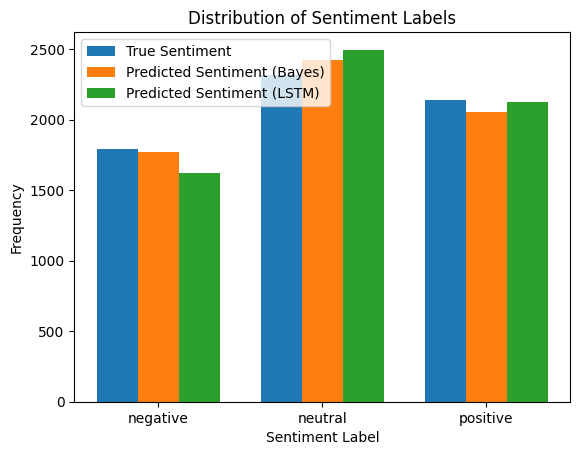

In [123]:
import numpy as np
import matplotlib.pyplot as plt

true_counts = test_df['sentiment'].value_counts().sort_index()
bayes_counts = test_df['predicted_sentiment_bayes'].value_counts().sort_index()
lstm_counts = test_df['predicted_sentiment_LSTM'].value_counts().sort_index()

labels = np.arange(len(true_counts))

bar_width = 0.25

plt.bar(labels - bar_width, true_counts, width=bar_width, label='True Sentiment')
plt.bar(labels, bayes_counts, width=bar_width, label='Predicted Sentiment (Bayes)')
plt.bar(labels + bar_width, lstm_counts, width=bar_width, label='Predicted Sentiment (LSTM)')

plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.xticks(labels, true_counts.index)

plt.legend()

plt.show()


In [127]:
# Calculate the correct counts for each sentiment label
bayes_correct_counts = test_df[test_df['predicted_sentiment_bayes'] == test_df['sentiment']]['predicted_sentiment_bayes'].value_counts().sort_index()
lstm_correct_counts = test_df[test_df['predicted_sentiment_LSTM'] == test_df['sentiment']]['predicted_sentiment_LSTM'].value_counts().sort_index()
# Calculate the total counts for each sentiment label
bayes_total_counts = test_df['predicted_sentiment_bayes'].value_counts().sort_index()
lstm_total_counts = test_df['predicted_sentiment_LSTM'].value_counts().sort_index()

# Calculate the accuracy for each model
bayes_accuracy = bayes_correct_counts / bayes_total_counts
lstm_accuracy = lstm_correct_counts / lstm_total_counts

print("Bayes Model Accuracy:")
print(bayes_accuracy)

print("\nLSTM Model Accuracy:")
print(lstm_accuracy)


Bayes Model Accuracy:
predicted_sentiment_bayes
negative    0.618859
neutral     0.562294
positive    0.714286
Name: count, dtype: float64

LSTM Model Accuracy:
predicted_sentiment_LSTM
negative    0.690462
neutral     0.606170
positive    0.753882
Name: count, dtype: float64


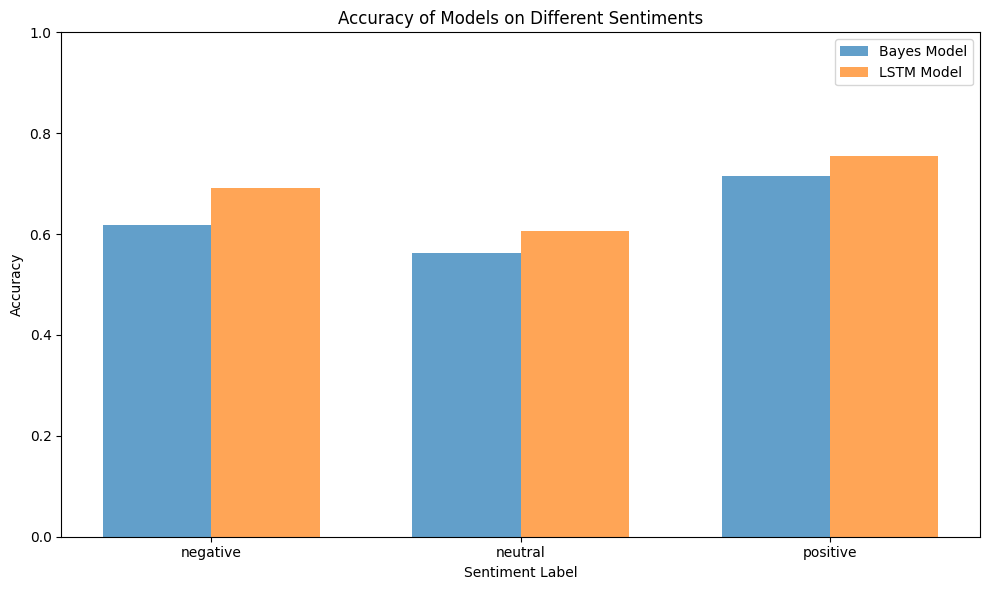

In [128]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sentiments = bayes_accuracy.index

labels = np.arange(len(sentiments))

bar_width = 0.35

plt.bar(labels - bar_width/2, bayes_accuracy, width=bar_width, label='Bayes Model', alpha=0.7)
plt.bar(labels + bar_width/2, lstm_accuracy, width=bar_width, label='LSTM Model', alpha=0.7)

plt.xlabel('Sentiment Label')
plt.ylabel('Accuracy')
plt.title('Accuracy of Models on Different Sentiments')
plt.xticks(labels, sentiments)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()
